NESTML Balanced Network Tutorial (CNS2020)
==========================================

Thus tutorial builds upon the previous one where we have implemented different variants of spike frequency adaptation mechanisms in a single neuron model. Here, we are going to assess the impact of these modifications at the population level, when the neurons are embedded in a large network with balanced excitation and inhibition, operating in an asynchronous irregular (AI) regime [[1](https://doi.org/10.1016/S0928-4257(00)01084-6)]. 

We will use the neuron models implemented in the previous tutorial and evaluate the characteristics of neuronal and population responses when driven by external input currents and Poissonian spike trains. Afterwards, we will use these neuron models in a recurrent balanced network and analyse the statistical properties of population responses and their modulation by SFA mechanisms. In a third section, we will perform a simple experiment where we perturb the input rate and evaluate the impact this has on population activity. On a last exercise, we will study the capacity of the network to encode information, i.e. to represent a time-dependent input signal. We will assess how SFA mechanisms can improve the accuracy of such representations.




#### **Table of contents:**
1. [Single neuron dynamics](#neuron)
    
2. [Balanced network dynamics](#network)

3. [Rate perturbation](#perturbation)

4. [Signal representation](#encoding)



---

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import itertools

from helper import SpikeList
from pynestml.frontend.pynestml_frontend import to_nest, install_nest

In [2]:
# system parameters
seed = 0
num_threads = 16
dt = 0.1

def reset_nest_kernel(seed, num_threads, dt):
    np.random.seed(seed)
    nest.ResetKernel()
    nest.SetKernelStatus({'grng_seed': seed, 'resolution': dt, 'print_time': True, 'local_num_threads': num_threads})

### **1. Single Neuron Dynamics**<a id='neuron'></a>

We will start by defining a set of routines to evaluate the properties of neuronal responses (similar to the previous tutorial):

In [3]:
def evaluate_neuron(neuron_name):
    t_simulation = 300. # [ms]
    reset_nest_kernel(seed, num_threads, dt)
    
    neuron = nest.Create(neuron_name)
    nest.SetStatus(neuron, "I_e", 500.)
    multimeter = nest.Create("multimeter")
    nest.SetStatus(multimeter, {"record_from": ["V_m"],
                    "interval": dt})
    spike_recorder = nest.Create("spike_recorder")
    nest.Connect(multimeter, neuron)
    nest.Connect(neuron, spike_recorder)
    
    nest.Simulate(t_simulation)

    dmm = nest.GetStatus(multimeter)[0]
    Voltages = dmm["events"]["V_m"]
    tv = dmm["events"]["times"]
    dSD = nest.GetStatus(spike_recorder, keys='events')[0]
    spikes = dSD['senders']
    ts = dSD["times"]
    
    _idx = [np.argmin((tv - spike_time)**2) - 1 for spike_time in ts]
    V_m_at_spike_times = Voltages[_idx]
    
    fig, ax = plt.subplots()
    ax.plot(tv, Voltages)
    ax.scatter(ts, V_m_at_spike_times)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("V_m [mV]")
    ax.grid()
    ax.set_xlim([0., t_simulation])

Now, we will implement and compare the different neuron models. The corresponding modules are ready to install, so we won't go through the code generation and compilation processes.

#### a) Base model, no adaptation:

In [4]:
nest.Install("nestml_iaf_psc_alpha_module")

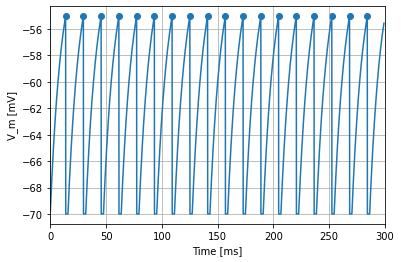

In [5]:
evaluate_neuron("iaf_psc_alpha_nestml") 

#### b) Threshold-based adaptation:

One of the options we will explore adds spike-frequency adaptation by increasing the firing threshold $\Theta$ by $\Delta\Theta$ the moment the neuron fires. Between firing events, $\Theta$ evolves according to:

\begin{align}
\frac{d\Theta}{dt} &= -(\Theta - \Theta_{init}) / \tau_\Theta
\end{align}

such that the firing threshold decays to its baseline value, in the absence of firing events, and $\tau_\Theta$ determines the decay rate.

In [6]:
nest.Install("nestml_sra_adapt_thresh_module")

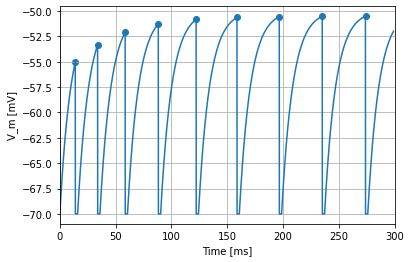

In [7]:
evaluate_neuron("iaf_psc_alpha_adapt_thresh_nestml") 

#### c) Current-based adaptation

A different approach is to incorporate an adaptation current $I_{sra}(t)$ while keeping the firing threshold constant. The dynamical system model is adjusted in this case to:

\begin{align}
\frac{dV_m}{dt} &= -(I_{syn} + I_{ext} + I_{sra}) / \tau_m\\
\frac{dI_{sra}}{dt} &= -I_{sra} / \tau_{sra}
\end{align}

where $I_{sra}$ is instantaneously increased by $\Delta{}I_{sra}$ at each the neuron fires and $\tau_{sra}$ controls the decay rate for the adaptation current.

In [8]:
nest.Install("nestml_sra_curr_module")

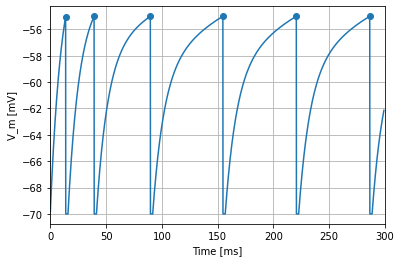

In [9]:
evaluate_neuron("iaf_psc_alpha_spike_rate_adapt_nestml")

#### d) Additional variants

If you have implemented additional modifications, as proposed in the previous tutorial, include them in the following list so they can be added to the model comparisons.

In [10]:
neuron_models = ["iaf_psc_alpha_nestml", "iaf_psc_alpha_spike_rate_adapt_nestml", "iaf_psc_alpha_adapt_thresh_nestml"]

----

#### **1.1. Single Neuron Characterization**

To further characterize the different neuron models, we will evaluate their transfer functions in the presence of current and rate inputs. For each analysis, we will measure the neuron's output firing rates, $CV_{ISI}$ and autocorrelation:

**Note:** To simplify the analysis, we provide the `SpikeList` class (adapted from [NeuroTools](http://neuralensemble.org/NeuroTools/), see `helper.py`) which implements the relevant analyses on population spike trains in a simple and convenient way. Throughout the examples, try different metrics and/or extend the scope of available methods by editing this class.

In [11]:
def measure_fI_curve(I_stim_vec, neuron_model_name):
    t_stop = 5000.   # simulate for a long time to make any startup transients insignificant [ms]

    rates = np.zeros_like(I_stim_vec)
    cvs = float("nan") * np.ones_like(I_stim_vec)
    corr = float("nan") * np.ones_like(I_stim_vec)
    
    for i, I_stim in enumerate(I_stim_vec):
        reset_nest_kernel(seed, num_threads, dt)
        neuron = nest.Create(neuron_model_name)

        dc = nest.Create("dc_generator", params={"amplitude": I_stim * 1E12}) # 1E12: convert A to pA
        nest.Connect(dc, neuron)

        sr_testant = nest.Create('spike_recorder')
        nest.Connect(neuron, sr_testant)

        nest.Simulate(t_stop)

        activity = nest.GetStatus(sr_testant, 'events')[0]
        tmp = [(k, t) for k, t in zip(activity['senders'], activity['times'])]
        sl = SpikeList(tmp, list(np.unique(activity['senders'])), t_start=0., t_stop=t_stop)
        
        if not sl.empty():
            rates[i] = sl.mean_rate()
            cvs[i] = np.nanmean(sl.cv_isi())
            corr[i] = np.mean(sl.autocorrelations())
    return rates, cvs, corr

In [12]:
def measure_rate_transfer(rate_stim_vec, neuron_model_name, wE):
    t_stop = 5000.
    
    rates = np.zeros_like(rate_stim_vec)
    cvs = float("nan") * np.ones_like(rate_stim_vec)
    corr = float("nan") * np.ones_like(rate_stim_vec)
    for i, stim in enumerate(rate_stim_vec):
        reset_nest_kernel(seed, num_threads, dt)
        neuron = nest.Create(neuron_model_name)

        pg = nest.Create("poisson_generator", params={"rate": stim * 1E3}) # 1E3: consider independent processes from 1E3 sources
        nest.Connect(pg, neuron, syn_spec={'delay': 1.5, 'weight': wE})

        sr_testant = nest.Create('spike_recorder')
        nest.Connect(neuron, sr_testant)

        nest.Simulate(t_stop)
        
        activity = nest.GetStatus(sr_testant, 'events')[0]
        tmp = [(k, t) for k, t in zip(activity['senders'], activity['times'])]
        sl = SpikeList(tmp, list(np.unique(activity['senders'])), t_start=0., t_stop=t_stop)
        
        if not sl.empty():
            rates[i] = sl.mean_rate()
            cvs[i] = np.nanmean(sl.cv_isi())
            corr[i] = np.mean(sl.autocorrelations())

    return rates, cvs, corr

In [13]:
def plot_IOcurves(I_stim_vec, label_to_rate_vec, ax=None, xlabel="", ylabel=""):
    if len(I_stim_vec) < 20:
        marker = "o"
    else:
        marker = None
    if ax is None:
        fig, ax = plt.subplots()
    ax = [ax]
    if isinstance(I_stim_vec, dict):
        for label, rate_vec in label_to_rate_vec.items():
            ax[0].plot(I_stim_vec[label], rate_vec, marker=marker, label=label)
    else:
        for label, rate_vec in label_to_rate_vec.items():
            ax[0].plot(I_stim_vec, rate_vec, marker=marker, label=label)
    for _ax in ax:
        _ax.legend(loc='upper right')
        _ax.grid()
        _ax.set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    plt.tight_layout()

We can now perform the analysis for the different neuron models:

**1. fI curves:** 

/home/neuro/Desktop/education/TA/CNS2020/helper.py:476: RuntimeWarning:invalid value encountered in double_scalars
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:Mean of empty slice.
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


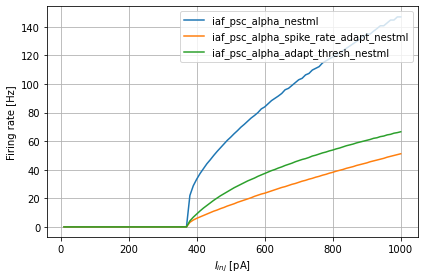

In [14]:
I_stim_vec = np.linspace(10E-12, 1E-9, 40)     # [A]
fI_curves = {}
cv_curves = {}
acc_curves = {}

for neuron in neuron_models:
    rate_vec, cvs_vec, acorr_vec = measure_fI_curve(I_stim_vec, neuron)
    fI_curves.update({neuron: rate_vec})
    cv_curves.update({neuron: cvs_vec})
    acc_curves.update({neuron: acorr_vec})

plot_IOcurves(I_stim_vec*1E12, fI_curves, xlabel="$I_{inj}$ [pA]", ylabel="Firing rate [Hz]")

**Task:** Determine the rheobase current ($I_{rh}$) and the slope of the fI curve for each of the neuron models.

**2. Rate transfer functions:** 

/home/neuro/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:Mean of empty slice.
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


(0.0, 75.0)

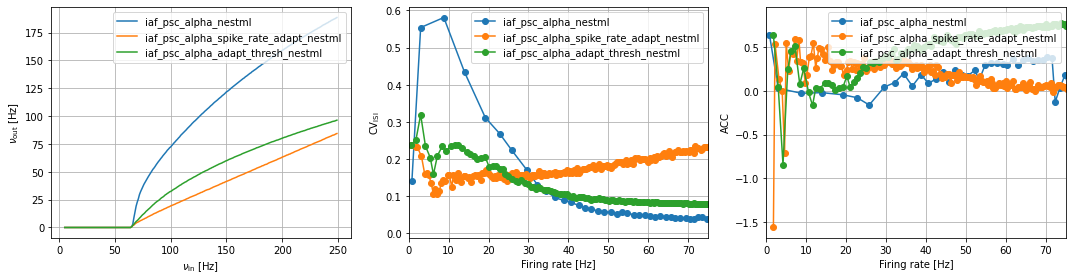

In [15]:
stim_vec = np.arange(5., 250., 5.)    # [Hz]
rate_curves = {}
cv_curves = {}
acc_curves = {}

for neuron in neuron_models:
    rate_vec, cvs_vec, acorr_vec = measure_rate_transfer(stim_vec, neuron, wE=1.)
    rate_curves.update({neuron: rate_vec})
    cv_curves.update({neuron: cvs_vec})
    acc_curves.update({neuron: acorr_vec})

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
plot_IOcurves(stim_vec, rate_curves, ax=ax[0], xlabel=r"$\nu_{\mathrm{in}}$ [Hz]", ylabel=r"$\nu_{\mathrm{out}}$ [Hz]")
plot_IOcurves(rate_curves, cv_curves, ax=ax[1], xlabel="Firing rate [Hz]", ylabel=r"$\mathrm{CV_{ISI}}$")
ax[1].set_xlim([0., 75.])
plot_IOcurves(rate_curves, acc_curves, ax=ax[2], xlabel="Firing rate [Hz]", ylabel=r"$\mathrm{ACC}$")
ax[2].set_xlim([0., 75.])

**Task:** Extend the analyses as suggested in the previous tutorial and evaluate the transfer functions in the presence of intrinsic noise (OU).

#### **1.2. Inhibitory modulation**

In this example, we emulate a neuron embedded in a large population. The neuron receives input from:

* $K^{X}=\epsilon N^{X}$ external, excitatory input synapses, where each external neuron fires at a rate $\nu^{X}$
* recurrent excitatory input from $K^{E}=\epsilon N^{E}$ synapses, with each excitatory neuron firing at a rate $\nu^{E}$
* recurrent inhibitory input from $K^{I}=\epsilon N^{I}$ synapses, with each inhibitory neuron firing at a rate $\nu^{I}$

We consider the neuron embedded in a network of $N=12500$ neurons ($N^{E}=N^{X}=0.8 N$ and $N^{I}=0.2 N$). For simplicity, we consider that all input populations fire at the same average rate, i.e. $\nu^{X}=\nu^{E}=\nu^{I}$.

The balance between excitatory and inhitory synaptic strengths is established by strengthening inhibitory synapses relative to excitatory ones: $w^{I}=\gamma w^{E}$.

<img src="figures/SingleNeuron-EI.png" width=600 height=600 />    

In [16]:
def balanced_ei_neuron(neuron_model_name, N, epsilon, p_rate, wE, gamma):
    
    KE = (0.8 * N) * epsilon
    KI = (0.2 * N) * epsilon
    
    reset_nest_kernel(seed, num_threads, dt)
    neuron = nest.Create(neuron_model_name)
    
    X_pg = nest.Create("poisson_generator", params={"rate": p_rate * KE})
    nest.Connect(X_pg, neuron, syn_spec={'delay': 1.5, 'weight': wE})

    E_pg = nest.Create("poisson_generator", params={"rate": p_rate * KE})
    nest.Connect(E_pg, neuron, syn_spec={'delay': 1.5, 'weight': wE})

    I_pg = nest.Create("poisson_generator", params={"rate": p_rate * KI})
    nest.Connect(I_pg, neuron, syn_spec={'delay': 1.5, 'weight': -gamma * wE})

    sr_testant = nest.Create('spike_recorder')

    nest.Connect(neuron, sr_testant)

    nest.Simulate(10000.)

    activity = nest.GetStatus(sr_testant, 'events')[0]
    tmp = [(k, t) for k, t in zip(activity['senders'], activity['times'])]
    sl = SpikeList(tmp, list(np.unique(activity['senders'])), t_start=0., t_stop=10000.)
    
    return sl

In [39]:
def evaluate_ei_neuron(rate_stim_vec, neuron_model_name, N, epsilon, w, g):
    rates = np.zeros_like(rate_stim_vec)
    cvs = float("nan") * np.ones_like(rate_stim_vec)
    corr = float("nan") * np.ones_like(rate_stim_vec)

    for i, rate in enumerate(rate_stim_vec):
        sl = balanced_ei_neuron(neuron_model_name, N, epsilon, p_rate=rate, wE=w, gamma=g)
        if not sl.empty():
            rates[i] = sl.mean_rate()
            cvs[i] = np.nanmean(sl.cv_isi())
            corr[i] = np.mean(sl.autocorrelations())
    return rates, cvs, corr

<ipython-input-39-6a396a5b60f2>:10: RuntimeWarning:Mean of empty slice
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning:Mean of empty slice.
/home/neuro/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


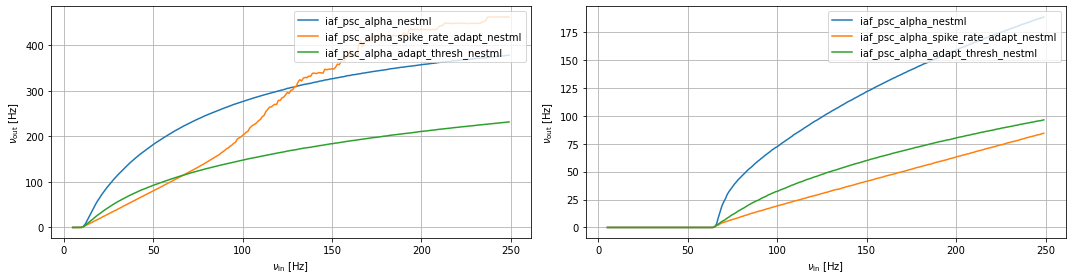

In [41]:
stim_vec = np.arange(5., 250., 5.)    
ei_rate_curves = {}
ei_cv_curves = {}
wE = 6.
gamma = 4.

for neuron in neuron_models:
    rate_vec, cvs_vec, corr_vec = evaluate_ei_neuron(stim_vec, neuron, N=10000., epsilon=0.1, w=wE, g=gamma)
    ei_rate_curves.update({neuron: rate_vec})
    ei_cv_curves.update({neuron: cvs_vec})

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_IOcurves(stim_vec, ei_rate_curves, ax=ax[0], xlabel=r"$\nu_{\mathrm{in}}$ [Hz]", ylabel=r"$\nu_{\mathrm{out}}$ [Hz]")
plot_IOcurves(stim_vec, rate_curves, ax=ax[1], xlabel=r"$\nu_{\mathrm{in}}$ [Hz]", ylabel=r"$\nu_{\mathrm{out}}$ [Hz]")

**Task:** Plot the results for CV and CC and evaluate the impact of inhibitory and excitatory synaptic strengths

----

### **2. Balanced Network Dynamics**<a id='network'></a>

In this section, we will analyze networks composed of $N=1000$ neurons, divided into $N^{E}=0.8 N$ excitatory and $N^{I}=0.2 N$ inhibitory neurons. Synaptic interactions are modelled as alpha-shaped currents, whose peak amplitude is scaled by $w$, with inhibitory synaptic weights larger than excitatory ones: $w^{I}=\gamma w^{E}$. All synaptic events originating from outside the network are assumed to be excitatory. 

If appropriately *balanced*, these networks are known to display complex behaviors and exhibit statistical properties similar to those exhibited by cortical circuits during active processing (see e.g. [[1](https://doi.org/10.1016/S0928-4257(00)01084-6)], [[2](https://doi.org/10.3389/fncom.2014.00124)], [[3](https://doi.org/10.1162/neco.2008.20.1.1)]). This *Asynchronous Irregular* regime is characterized by low firing rates, irregular neuronal firing ($\mathrm{CV_{ISI}}\approx1$) and asynchronous population activity ($\mathrm{CC}\leq0.1$).

<img src="figures/Net.png" width=600 height=600 />                  <img src="figures/EI_dynamics.png" width=500 height=500 />

As with the single neuron experiments, we will start by defining a set of routines to setup the network and evaluate the properties of population responses:

In [42]:
def create_network(neuron_model, N=1000, epsilon=0.1, wE=20., gamma=20.):    
    # network parameters
    nE = int(N * 0.8)
    nI = int(N * 0.2)
    
    # create populations
    neurons_e = nest.Create(neuron_model, nE)
    neurons_i = nest.Create(neuron_model, nI)
    
    # connect
    syn_exc = {'delay': 1.5, 'weight': wE}
    conn_exc = {'rule': 'pairwise_bernoulli', 'p': epsilon}
    
    syn_inh = {'delay': 1.5, 'weight': - gamma * wE}
    conn_inh = {'rule': 'pairwise_bernoulli', 'p': epsilon}
    
    if epsilon > 0.:
        nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc) # E->E
        nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc) # E->I
        nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh) # I->E
        nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh) # I->I
       
    return neurons_e, neurons_i, syn_exc, syn_inh

In [43]:
def set_recording_devices(neurons_e, neurons_i, start=0., stop=1000.):
    spikes_e = nest.Create('spike_recorder')
    nest.SetStatus(spikes_e, {'start': start, 'stop': stop})
    spikes_i = nest.Create('spike_recorder')
    nest.SetStatus(spikes_i, {'start': start, 'stop': stop})

    nest.Connect(neurons_e, spikes_e)
    nest.Connect(neurons_i, spikes_i)
    return spikes_e, spikes_i

In [44]:
def evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec, p_rate=10000., start=0., stop=1000.):
    
    noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'start': start, 'stop': stop})

    # connect poisson generator using the excitatory connection weight
    nest.Connect(noise_pgen, neurons_i, syn_spec=syn_spec)
    nest.Connect(noise_pgen, neurons_e, syn_spec=syn_spec)
    
    nest.Simulate(stop-start)
    
    e_activity = nest.GetStatus(spikes_e, 'events')[0]
    i_activity = nest.GetStatus(spikes_i, 'events')[0]
    
    tmp = [(k, t) for k, t in zip(e_activity['senders'], e_activity['times'])]
    sl_e = SpikeList(tmp, list(np.unique(e_activity['senders'])), t_start=start, t_stop=stop)
    
    tmp = [(k, t) for k, t in zip(i_activity['senders'], i_activity['times'])]
    sl_i = SpikeList(tmp, list(np.unique(i_activity['senders'])), t_start=start, t_stop=stop)
    
    return sl_e, sl_i    

In [45]:
def characterize_population_activity(e_spike_list, i_spike_list, start=0., transient=100., stop=1000., title='', plot=True):
    e_spike_list = e_spike_list.time_slice(t_start=transient, t_stop=stop)
    i_spike_list = i_spike_list.time_slice(t_start=transient, t_stop=stop)
    
    ids = np.array(list(itertools.chain(*[e_spike_list.id_list, i_spike_list.id_list])))
    network_activity = e_spike_list.copy()
    network_activity.concatenate(i_spike_list)
    e_rates = np.array(e_spike_list.mean_rates())
    i_rates = np.array(i_spike_list.mean_rates())
    e_cvs = e_spike_list.cv_isi()
    i_cvs = i_spike_list.cv_isi()
    e_ccs = e_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True)
    i_ccs = i_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True)
    
    if plot:
        fig = plt.figure(figsize=(20, 10))
        fig.suptitle(title)
        ax1 = plt.subplot2grid((30, 20), (0, 0), rowspan=23, colspan=16)
        ax2 = plt.subplot2grid((30, 20), (24, 0), rowspan=5, colspan=16, sharex=ax1)
        ax2.set(xlabel='Time [ms]', ylabel='Rate')
        ax1.set(ylabel='Neuron')

        ax3 = plt.subplot2grid((30, 20), (0, 17), rowspan=10, colspan=10)
        ax4 = plt.subplot2grid((30, 20), (11, 17), rowspan=10, colspan=3)
        ax5 = plt.subplot2grid((30, 20), (22, 17), rowspan=10, colspan=3)

        ax1.plot(e_spike_list.raw_data()[:, 0], e_spike_list.raw_data()[:, 1], '.', c='b')
        ax1.plot(i_spike_list.raw_data()[:, 0], i_spike_list.raw_data()[:, 1], '.', c='r')
        ax1.set_xlim([start+transient, stop])
        ax1.set_ylim([ids.min(), ids.max()])

        ax2.plot(e_spike_list.time_axis(1.)[:-1], e_spike_list.firing_rate(1., average=True), lw=1, c='b', alpha=0.3)
        ax2.plot(i_spike_list.time_axis(1.)[:-1], i_spike_list.firing_rate(1., average=True), lw=1, c='r', alpha=0.3)
        ax2.plot(e_spike_list.time_axis(10.)[:-1], e_spike_list.firing_rate(10., average=True), lw=2, c='b')
        ax2.plot(i_spike_list.time_axis(10.)[:-1], i_spike_list.firing_rate(10., average=True), lw=2, c='r')
        ax2.set_xlim([start+transient, stop])

        _ = ax3.hist(e_rates[e_rates!=0.], color='b', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        _ = ax3.hist(i_rates[i_rates!=0.], color='r', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        ax3.set_xlabel("Firing rate [Hz]")

        _ = ax4.hist(e_cvs[~np.isnan(e_cvs)], color='b', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        _ = ax4.hist(i_cvs[~np.isnan(i_cvs)], color='r', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        ax4.set_xlabel(r"$\mathrm{CV_{ISI}}$")

        _ = ax5.hist(e_ccs[~np.isnan(e_ccs)], color='b', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        _ = ax5.hist(i_ccs[~np.isnan(i_ccs)], color='r', histtype='stepfilled', alpha=0.3, density=True, bins=100)
        ax5.set_xlabel(r"$\mathrm{CC}$")
        plt.tight_layout()
    
    print("\n######## {} ########".format(title))
    print("- Mean firing rate: {0} spikes/s\n\tE = {1} spikes/s\n\tI = {2} spikes/s".format(
        network_activity.mean_rate(), e_spike_list.mean_rate(), i_spike_list.mean_rate()))
    print("- Mean CV_ISI: {0} \n\tE = {1} \n\tI = {2}".format(
        np.nanmean(network_activity.cv_isi()), np.nanmean(e_spike_list.cv_isi()), np.nanmean(i_spike_list.cv_isi())))
    print("- Mean Pairwise CC: {0} \n\tE = {1} \n\tI = {2}".format(
        network_activity.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1.)[0], 
        e_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1.)[0], 
        i_spike_list.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1.)[0]))
    
    return e_spike_list, i_spike_list

We can now evaluate the population dynamics for the different neuron models and evaluate the statistics of population activity for the different models:

<ipython-input-45-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## iaf_psc_alpha_nestml ########
- Mean firing rate: 13.757575757575758 spikes/s
	E = 13.68951048951049 spikes/s
	I = 14.034090909090908 spikes/s
- Mean CV_ISI: 0.587207144841757 
	E = 0.5973638819709555 
	I = 0.5470069499858538
- Mean Pairwise CC: -0.00198736757149311 
	E = 0.002802236016478302 
	I = 0.004582881338516157


<ipython-input-45-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## iaf_psc_alpha_spike_rate_adapt_nestml ########
- Mean firing rate: 9.032064128256513 spikes/s
	E = 8.94486215538847 spikes/s
	I = 9.38 spikes/s
- Mean CV_ISI: 0.5377399279935787 
	E = 0.535940961453196 
	I = 0.5446876608391945
- Mean Pairwise CC: 0.0020945865375404933 
	E = 0.002138879752619105 
	I = 0.0008114954716645717


<ipython-input-45-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## iaf_psc_alpha_adapt_thresh_nestml ########
- Mean firing rate: 10.414213197969543 spikes/s
	E = 10.36594663278272 spikes/s
	I = 10.606060606060606 spikes/s
- Mean CV_ISI: 0.6166965856393648 
	E = 0.6100783877658614 
	I = 0.6428425525470326
- Mean Pairwise CC: 0.004713738430627911 
	E = 0.000673111695665219 
	I = 0.0016991673415270162


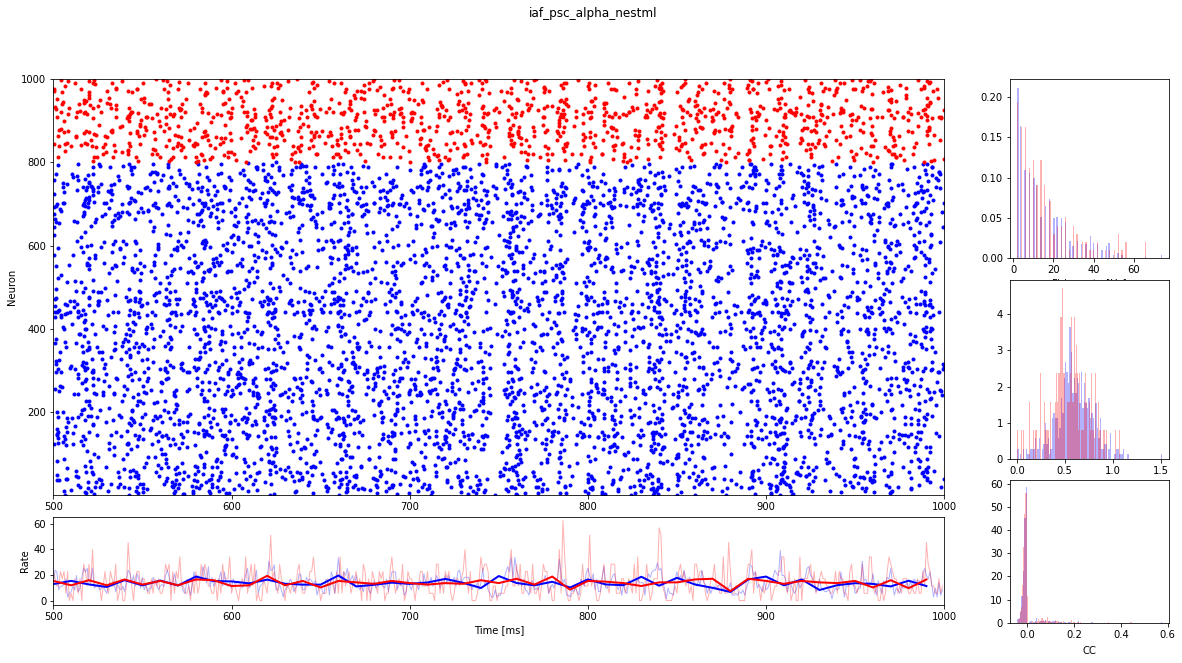

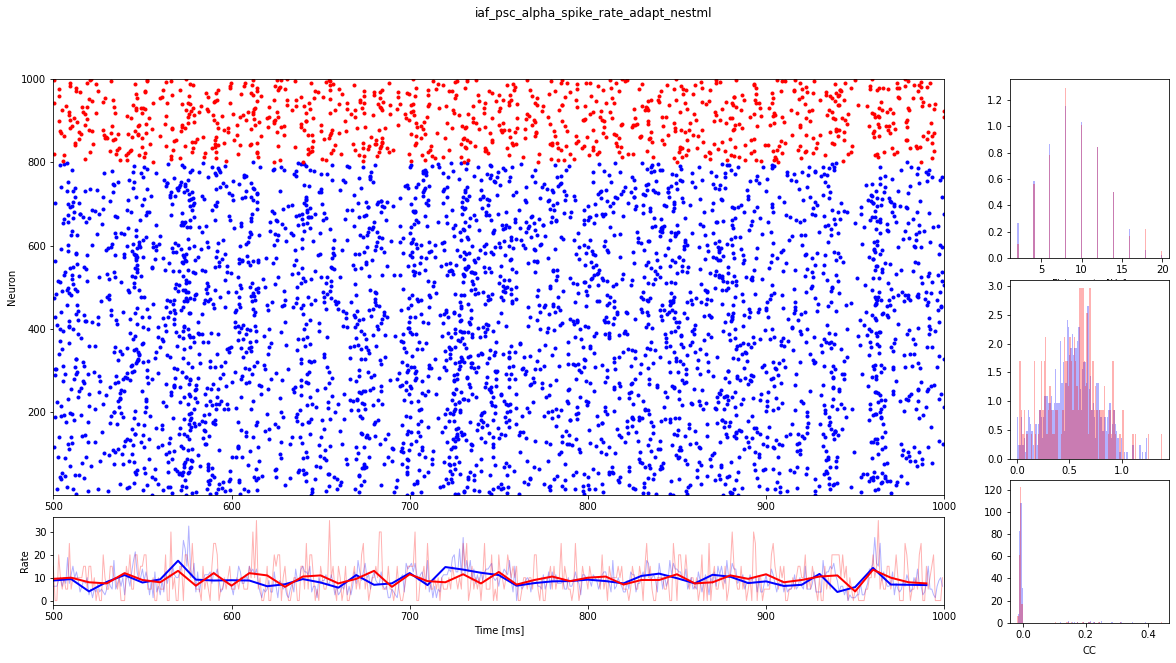

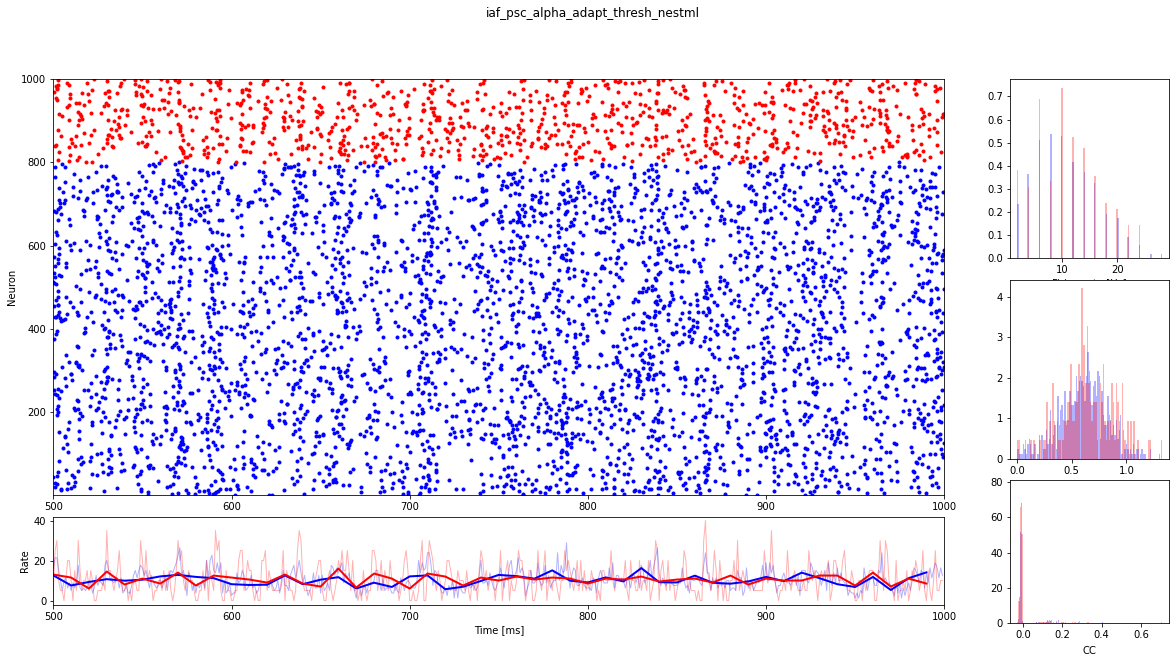

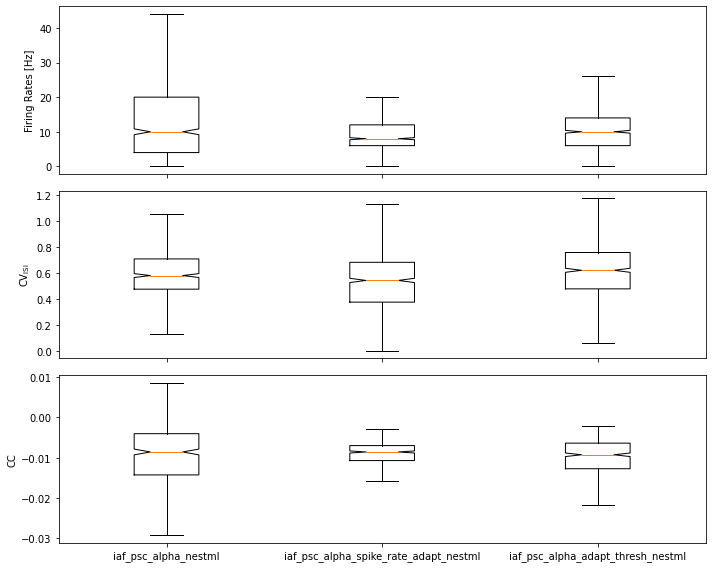

In [46]:
sim_time = 1000.
neuron_models = ["iaf_psc_alpha_nestml", "iaf_psc_alpha_spike_rate_adapt_nestml", "iaf_psc_alpha_adapt_thresh_nestml"]

rates = []
cvs = []
ccs = []

for neuron_model in neuron_models:
    reset_nest_kernel(seed, num_threads, dt)
    neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1)
    spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
    e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000., start=0., stop=sim_time)
    e_activity, i_activity = characterize_population_activity(e_activity, i_activity, start=0., transient=500., stop=sim_time, title=neuron_model, plot=True)
    
    network_activity = e_activity.copy()
    network_activity.concatenate(i_activity)
    
    rates.append(network_activity.mean_rates())
    cvs.append(network_activity.cv_isi(True))
    ccs.append(network_activity.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True))

fig, ax = plt.subplots(3, 1, figsize=(10, 8))
pos = np.arange(1, len(neuron_models)+1, 1)
ax[0].boxplot(rates, notch=1, positions=pos, vert=1, sym='')
ax[0].set_ylabel("Firing Rates [Hz]")
ax[0].set_xticklabels([])
ax[1].boxplot(cvs, notch=1, positions=pos, vert=1, sym='')
ax[1].set_ylabel(r"$\mathrm{CV_{ISI}}$")
ax[1].set_xticklabels([])
ax[2].boxplot(ccs, notch=1, positions=pos, vert=1, sym='')
ax[2].set_ylabel("CC")
ax[2].set_xticks(pos)
ax[2].set_xticklabels(neuron_models)
plt.tight_layout()

**Task:** The characteristics of population responses are determined primarily by the strength of external inputs and recurrent interactions. Explore these effects by modifying the excitatory weight `wE`, the inhibition-to-excitation ratio `gamma` and/or other relevant parameters (connection density `epsilon`, input rate `p_rate` or network size `N`)  

### **3. Rate perturbation**<a id='perturbation'></a>

We will now perform a simple experiment where we perturb the input firing rate and evaluate how the population adapts in the presence of the different intrinsic adaptation mechanisms

<ipython-input-45-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## Before ########
- Mean firing rate: 13.159501061571126 spikes/s
	E = 13.187804338202744 spikes/s
	I = 13.046737213403878 spikes/s
- Mean CV_ISI: 0.7471568369477458 
	E = 0.7503745117936941 
	I = 0.7338961163705046
- Mean Pairwise CC: 0.0010683003153386364 
	E = 0.0021757339435422127 
	I = 0.0011241755055076289


<ipython-input-45-9d6d688ec268>:49: UserWarning:Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations



######## After ########
- Mean firing rate: 18.08961737793538 spikes/s
	E = 18.041986025179302 spikes/s
	I = 18.286989795918366 spikes/s
- Mean CV_ISI: 0.7285505500659748 
	E = 0.7305471844952491 
	I = 0.7202589709777385
- Mean Pairwise CC: 0.014313495934775364 
	E = 0.015907026013833297 
	I = 0.014342880760493112


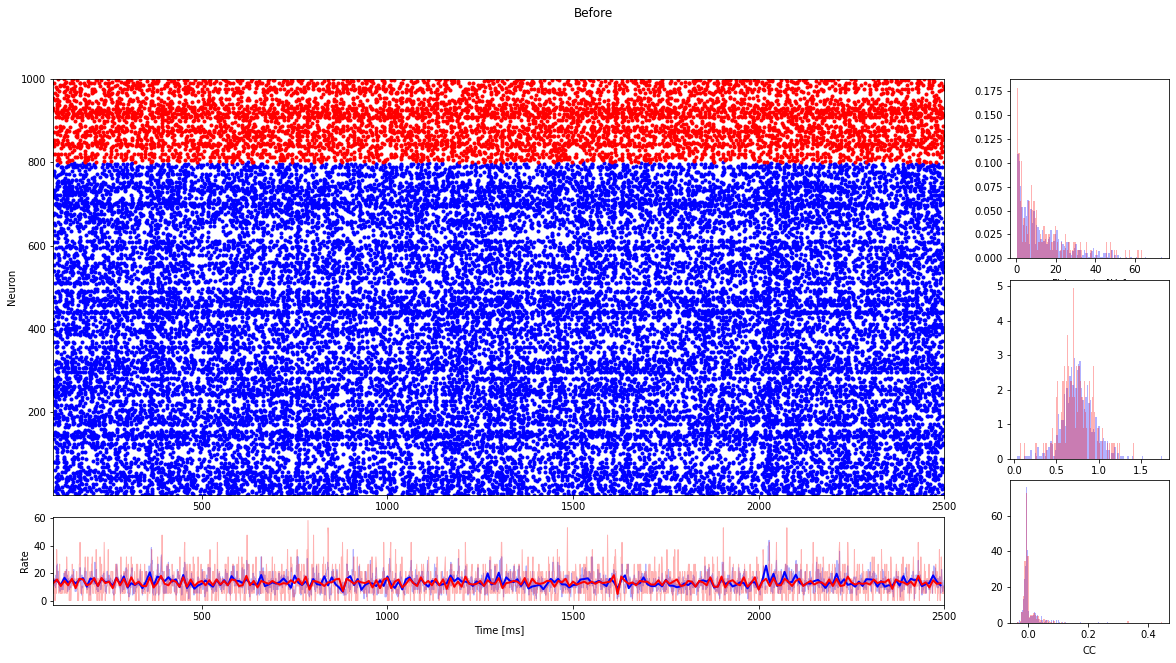

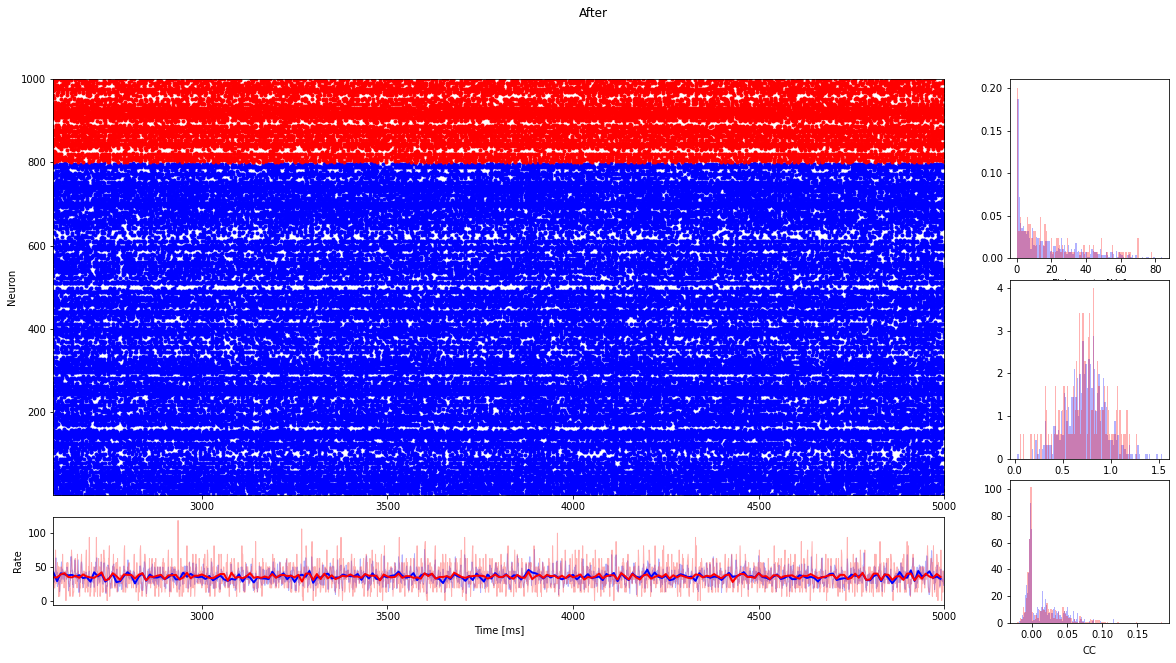

In [47]:
sim_time = 5000.
perturbation_time = 2500.
rate_scale = 2.
neuron_model = "iaf_psc_alpha_nestml"

reset_nest_kernel(seed, num_threads, dt)
neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1)

spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=perturbation_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000., start=0., stop=perturbation_time)
e_activity_pre, i_activity_pre = characterize_population_activity(e_activity, i_activity, start=0., transient=100., stop=perturbation_time, title='Before')

spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=perturbation_time, stop=sim_time)
e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000.*rate_scale, start=perturbation_time, stop=sim_time)

e_activity_post, i_activity_post = characterize_population_activity(e_activity, i_activity, start=perturbation_time, transient=100., stop=sim_time, title='After')

Now let's compare how the response to the perturbation differs when the network is composed of the different neuron models with SFA: 


######## iaf_psc_alpha_nestml - Before ########
- Mean firing rate: 13.159501061571126 spikes/s
	E = 13.187804338202744 spikes/s
	I = 13.046737213403878 spikes/s
- Mean CV_ISI: 0.7471568369477458 
	E = 0.7503745117936941 
	I = 0.7338961163705046
- Mean Pairwise CC: 0.0010683003153386364 
	E = 0.0021757339435422127 
	I = 0.0011241755055076289

######## iaf_psc_alpha_nestml - After ########
- Mean firing rate: 18.08961737793538 spikes/s
	E = 18.041986025179302 spikes/s
	I = 18.286989795918366 spikes/s
- Mean CV_ISI: 0.7285505500659748 
	E = 0.7305471844952491 
	I = 0.7202589709777385
- Mean Pairwise CC: 0.014313495934775364 
	E = 0.015907026013833297 
	I = 0.014342880760493112

######## iaf_psc_alpha_spike_rate_adapt_nestml - Before ########
- Mean firing rate: 9.295416666666668 spikes/s
	E = 9.2671875 spikes/s
	I = 9.408333333333335 spikes/s
- Mean CV_ISI: 0.6265258246117288 
	E = 0.6261155341981499 
	I = 0.6281649348139763
- Mean Pairwise CC: 0.0017165825931849163 
	E = -0.00021894889

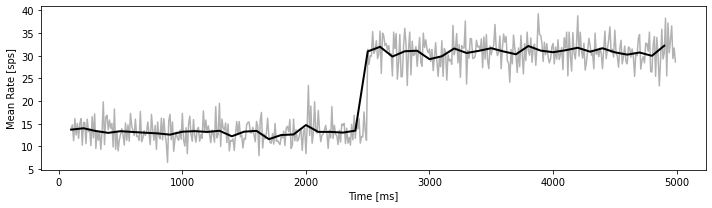

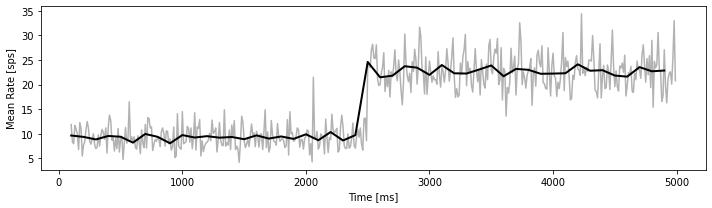

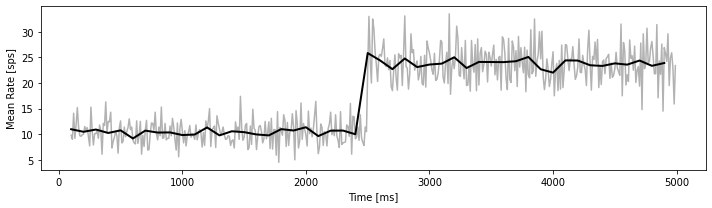

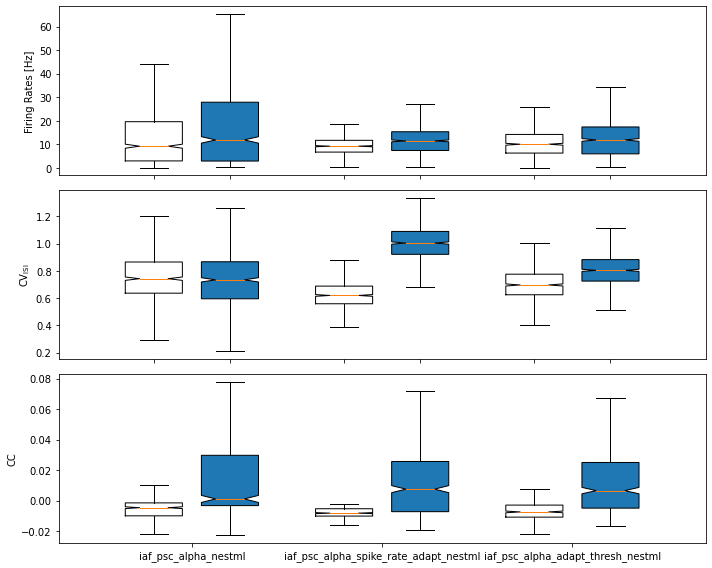

In [48]:
sim_time = 5000.
perturbation_time = 2500.
rate_scale = 2.
neuron_models = ["iaf_psc_alpha_nestml", "iaf_psc_alpha_spike_rate_adapt_nestml", "iaf_psc_alpha_adapt_thresh_nestml"]

rates_pre = []
rates_post = []
cvs_pre = []
cvs_post = []
ccs_pre = []
ccs_post = []

for neuron_model in neuron_models:
    reset_nest_kernel(seed, num_threads, dt)
    neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1)

    spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=perturbation_time)
    e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000., start=0., stop=perturbation_time)
    e_activity_pre, i_activity_pre = characterize_population_activity(e_activity, i_activity, start=0., transient=100., stop=perturbation_time, plot=False, title="{} - Before".format(neuron_model))

    spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=perturbation_time, stop=sim_time)
    e_activity, i_activity = evaluate_network(neurons_e, neurons_i, spikes_e, spikes_i, syn_spec=syn_exc, p_rate=5000.*rate_scale, start=perturbation_time, stop=sim_time)

    e_activity_post, i_activity_post = characterize_population_activity(e_activity, i_activity, start=perturbation_time, transient=100., stop=sim_time, plot=False, title="{} - After".format(neuron_model))
    
    network_activity_pre = e_activity_pre.copy()
    network_activity_pre.concatenate(i_activity_pre)

    network_activity_post = e_activity_post.copy()
    network_activity_post.concatenate(i_activity_post)

    network_activity = network_activity_pre.copy()
    network_activity.merge(network_activity_post)

    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(network_activity.time_axis(10.)[:-1], network_activity.firing_rate(10., average=True), c='k', alpha=0.3)
    ax.plot(network_activity.time_axis(100.)[:-1], network_activity.firing_rate(100., average=True), c='k', lw=2)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Mean Rate [sps]")
    plt.tight_layout()
    
    rates_pre.append(network_activity_pre.mean_rates())
    rates_post.append(network_activity_post.mean_rates())
    cvs_pre.append(network_activity_pre.cv_isi(True))
    cvs_post.append(network_activity_post.cv_isi(True))
    ccs_pre.append(network_activity_pre.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True))
    ccs_post.append(network_activity_post.pairwise_pearson_corrcoeff(nb_pairs=500, time_bin=1., all_coef=True))

fig, ax = plt.subplots(3, 1, figsize=(10, 8))
pos1 = np.arange(1, len(neuron_models)+1, 1) - 0.2
pos2 = np.arange(1, len(neuron_models)+1, 1) + 0.2

ax[0].boxplot(rates_pre, notch=1, positions=pos1, vert=1, sym='')
ax[0].boxplot(rates_post, notch=1, positions=pos2, vert=1, sym='', patch_artist=True)
ax[0].set_ylabel("Firing Rates [Hz]")
ax[0].set_xticklabels([])

ax[1].boxplot(cvs_pre, notch=1, positions=pos1, vert=1, sym='')
ax[1].boxplot(cvs_post, notch=1, positions=pos2, vert=1, sym='', patch_artist=True)
ax[1].set_ylabel(r"$\mathrm{CV_{ISI}}$")
ax[1].set_xticklabels([])

ax[2].boxplot(ccs_pre, notch=1, positions=pos1, vert=1, sym='')
ax[2].boxplot(ccs_post, notch=1, positions=pos2, vert=1, sym='', patch_artist=True)
ax[2].set_ylabel("CC")
ax[2].set_xticks(pos1+0.2)
ax[2].set_xticklabels(neuron_models)
plt.tight_layout()

### **4. Signal Representation**<a id='encoding'></a>

By introducing longer timescales in the neuron dynamics, it has been hypothesized that spike frequency adaptation mechanisms may improve the circuit's ability to internally represent a dynamic input signal and improve the system's working memory capacity (see e.g. [[4](https://doi.org/10.1101/546325)]). In this example, we will quantify the impact of the different adaptation mechanisms in the system's ability to represent a time-dependent input signal. 

In [49]:
from helper import generate_input, convolve_spk, compute_capacity
from sklearn.decomposition import PCA

In these experiments, the network is driven by a time-varying signal $u(t)$ whose values are i.i.d. from a uniform distribution.  

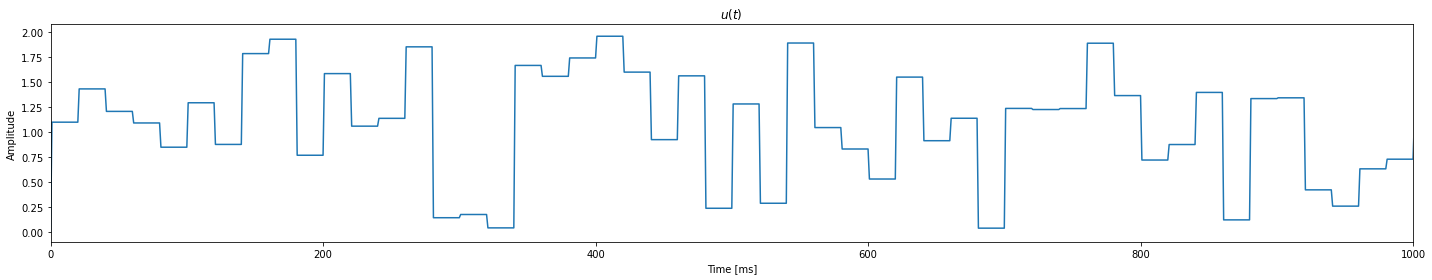

In [58]:
step_duration = 20.   # duration of each step [ms]
scale = 10000.         # input scaling factor [Hz]
num_steps = 100       # number of unique input values
dt = 1.               # input resolution [ms]

sig, times, inp_times, inp_amplitudes = generate_input(num_steps=num_steps, step_duration=step_duration, resolution=dt, scale=scale)

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')
fig.tight_layout()

In [59]:
def stimulus_representation(neuron_model, input_times, input_amplitudes, sig):
    sim_time = num_steps*step_duration

    reset_nest_kernel(seed, num_threads, dt)
    
    neurons_e, neurons_i, syn_exc, syn_inh = create_network(neuron_model=neuron_model, N=1000, epsilon=0.1)
    spikes_e, spikes_i = set_recording_devices(neurons_e, neurons_i, start=0., stop=sim_time)
    
    # create inhomogeneous poisson generator (time-dependent input signal)
    stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
    nest.SetStatus(stim_pgen, params={'rate_times': input_times, 'rate_values': input_amplitudes})
    nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
    nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)
    
    nest.Simulate(sim_time)
    
    activity = nest.GetStatus(spikes_e, 'events')[0]
    recorded_neurons = np.unique(activity['senders'])
    filter_tau = 100. # [ms]
    states = convolve_spk(activity['times'], activity['senders'], recorded_neurons, sim_time, filter_tau, dt)
    
    estimate, capacity, error, norm = compute_capacity(states, sig[:-1])
    print("\n####### {0} ####### \nCapacity={1}, MSE={2}".format(neuron_model, str(round(capacity, 2)), str(round(error, 2))))
    
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle('{0} Representation Accuracy [C={1}]'.format(neuron_model, str(capacity)))
    ax11 = fig.add_subplot(211)
    ax12 = fig.add_subplot(212, sharex=ax11)
    ax11.plot(activity['times'], activity['senders'], '.k', markersize=1)
    ax11.set_xlim([0., sim_time])
    ax12.plot(times, sig, 'r', linewidth=2)
    ax12.plot(times[:-1], estimate, 'k', linewidth=1)
    ax12.set_xlabel(r'Time [ms]')
    plt.show()
    
    return estimate, capacity, error

Let's evaluate the representation capacity of balanced networks composed of the different neuron types developed.


####### iaf_psc_alpha_nestml ####### 
Capacity=0.84, MSE=0.05


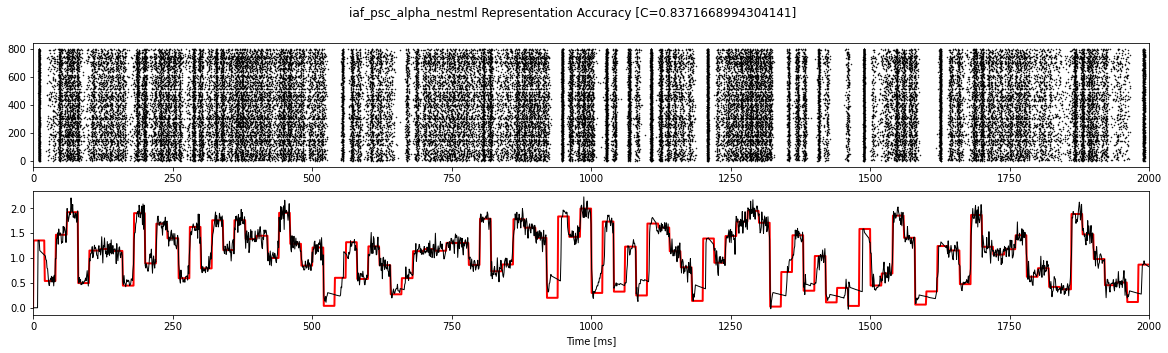


####### iaf_psc_alpha_spike_rate_adapt_nestml ####### 
Capacity=0.81, MSE=0.06


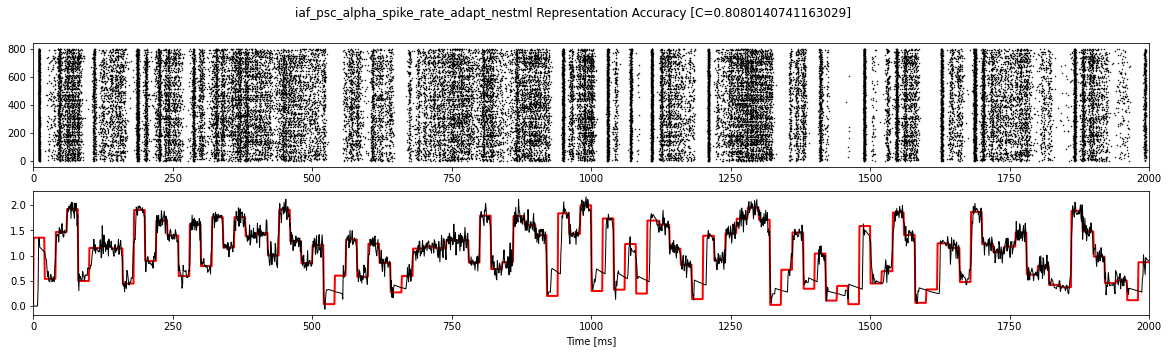


####### iaf_psc_alpha_adapt_thresh_nestml ####### 
Capacity=0.82, MSE=0.06


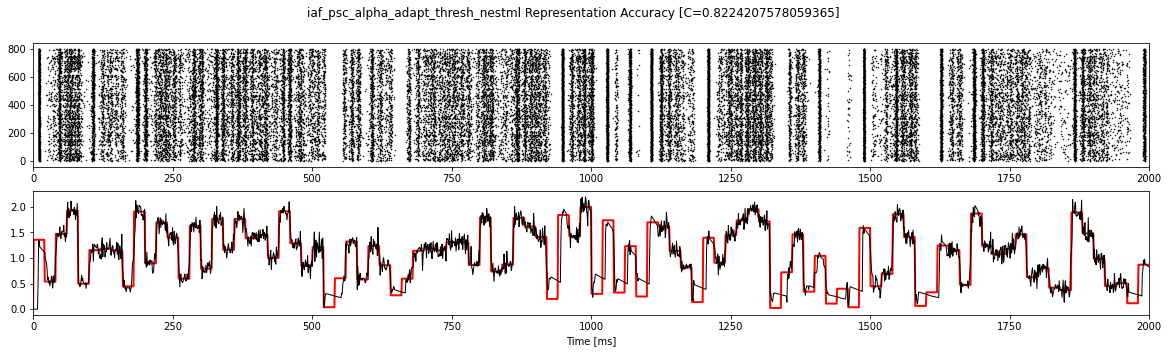

In [60]:
neuron_models = ["iaf_psc_alpha_nestml", "iaf_psc_alpha_spike_rate_adapt_nestml", "iaf_psc_alpha_adapt_thresh_nestml"]
sig, times, inp_times, inp_amplitudes = generate_input(num_steps=num_steps, step_duration=step_duration, resolution=dt, scale=scale)

c = []
e = []
for neuron in neuron_models:
    z_hat, cap, err = stimulus_representation(neuron, inp_times, inp_amplitudes, sig)
    c.append(cap)
    e.append(err)

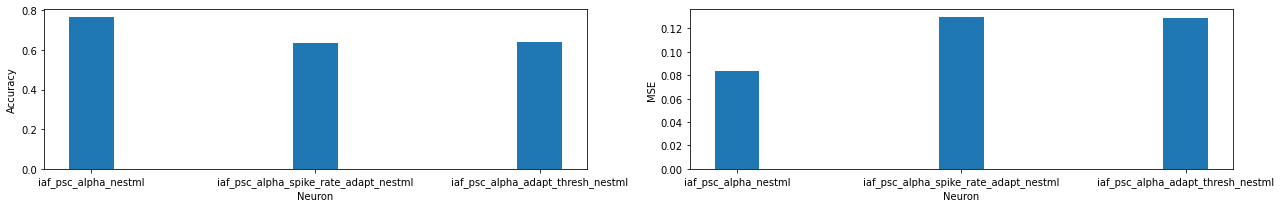

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(18, 3))
ax[0].bar(np.arange(len(neuron_models)), c, width=0.2)
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Neuron")
ax[0].set_xticks(np.arange(len(neuron_models)))
# ax[0].set_ylim([0.75, 0.79])
ax[0].set_xticklabels(neuron_models)
ax[1].bar(np.arange(len(neuron_models)), e, width=0.2)
ax[1].set_xticks(np.arange(len(neuron_models)))
ax[1].set_ylabel("MSE")
ax[1].set_xlabel("Neuron")
ax[1].set_xticklabels(neuron_models)
# ax[1].set_ylim([0.06, 0.08])
plt.tight_layout()

**Task:** Evaluate the statistics of population responses during signal processing.

**Task:** Explore different parameter regimes for the input signal (`step_duration`, `scale`, etc.)

---

**References:**

[[1](https://doi.org/10.1016/S0928-4257(00)01084-6)] Brunel, N. (2000). Dynamics of networks of randomly connected excitatory and inhibitory spiking neurons. Journal of Physiology Paris, 94(5–6), 445–463.

[[2](https://doi.org/10.3389/fncom.2014.00124)] Duarte, R. C. F., & Morrison, A. (2014). Dynamic stability of sequential stimulus representations in adapting neuronal networks. Frontiers in Computational Neuroscience, 8(124), 124. 

[[3](https://doi.org/10.1162/neco.2008.20.1.1)] Kumar, A., Schrader, S., Aertsen, A., & Rotter, S. (2008). The high-conductance state of cortical networks. Neural Computation, 20(1), 1–43. 

[[4](https://doi.org/10.1101/546325)] Fitz, H., Uhlmann, M., Broek, D. van den, Duarte, R., Hagoort, P., & Petersson, K. M. (2019). Neuronal memory for language processing. BioRxiv, 546325.